Импорт библиотек

In [887]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

Смотрим исходные данные

In [888]:
train = pd.read_excel("data/train.xlsx")
test = pd.read_excel("data/test.xlsx")

arr = [train, test]
names_df = ['train', 'test']

def analyze_data(data, name):
      print(f'Анализ данных для {name}:')
      print(data.describe())

def perenos_():
      print('\n******************************************************************\n')

def NaN_check(df):
      print("NaN после обработки:")
      print(df.isna().sum())

for i, elem in enumerate(arr):
    analyze_data(elem, names_df[i])

Анализ данных для train:
                        dt  Цена на арматуру
count                  400        400.000000
mean   2018-11-01 12:00:00      39229.475000
min    2015-01-05 00:00:00      21000.000000
25%    2016-12-03 06:00:00      31075.000000
50%    2018-11-01 12:00:00      35450.000000
75%    2020-09-29 18:00:00      42000.000000
max    2022-08-29 00:00:00      79000.000000
std                    NaN      13407.979668
Анализ данных для test:
                        dt  Цена на арматуру
count                   28         28.000000
mean   2022-12-08 12:00:00      44250.000000
min    2022-09-05 00:00:00      40000.000000
25%    2022-10-22 06:00:00      41925.000000
50%    2022-12-08 12:00:00      42900.000000
75%    2023-01-24 18:00:00      45625.000000
max    2023-03-13 00:00:00      55500.000000
std                    NaN       3645.951585


In [889]:
for i, elem in enumerate(arr):
     # Смотрим info
     print(f'Инфо {names_df[i]}')
     elem.info()

     # Смотрим кол-во строк + столбцов
     print(f"\n{names_df[i]} имеет: {elem.shape[0]} строк, {elem.shape[1]} столбца")

     # Смотрим колонки с разными типами данных
     numeric_columns = elem.select_dtypes(include=['int64', 'float64']).columns
     dt_columns = elem.select_dtypes(include=['datetime64']).columns

     # Выводим колонки     
     print(f"\nКол-во 'Числовых' колонок в {names_df[i]}: {len(numeric_columns)}")
     print(f"\nКол-во 'Дата-Тайм' колонок в {names_df[i]}: {len(numeric_columns)}")

     perenos_()

Инфо train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB

train имеет: 400 строк, 2 столбца

Кол-во 'Числовых' колонок в train: 1

Кол-во 'Дата-Тайм' колонок в train: 1

******************************************************************

Инфо test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                28 non-null     datetime64[ns]
 1   Цена на арматуру  28 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 580.0 bytes

test имеет: 28 строк, 2 столбца

Кол-во 

In [890]:
def propuski(train_data, test_data):
    isxod_train = train_data.isnull().sum()
    isxod_test = test_data.isnull().sum()

    # Объединяем результаты в DataFrame
    combined_isxod = pd.concat([isxod_train, isxod_test], axis=1)
    combined_isxod.columns = ['Train', 'Test']

    # Выводим результат
    print(combined_isxod)

propuski(train, test)

                  Train  Test
dt                    0     0
Цена на арматуру      0     0


In [891]:
train.head(3)

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000


In [892]:
test.head(3)

,dt,Цена на арматуру
0,2022-09-05,46000
1,2022-09-12,46000
2,2022-09-19,46000


In [893]:
print(f"Train data ot: {train['dt'].min()} do {train['dt'].max()}")
perenos_()
print(f"Test data ot: {test['dt'].min()} do {test['dt'].max()}")
perenos_()
print(train.isna().sum())
perenos_()
print(test.isna().sum())

Train data ot: 2015-01-05 00:00:00 do 2022-08-29 00:00:00

******************************************************************

Test data ot: 2022-09-05 00:00:00 do 2023-03-13 00:00:00

******************************************************************

dt                  0
Цена на арматуру    0
dtype: int64

******************************************************************

dt                  0
Цена на арматуру    0
dtype: int64


Обучение // модель CatBoost

In [894]:
pd.options.mode.copy_on_write = True

# Временные признаки
train['year'] = train['dt'].dt.year
train['month'] = train['dt'].dt.month 
train['weekday'] = train['dt'].dt.weekday 
train["dayofyear"] = train["dt"].dt.dayofyear 
train["quarter"] = train["dt"].dt.quarter

# Лаги (учитываются последние 5 недель)
for lag in range(1, 6):
    train[f"lag_{lag}"] = train["Цена на арматуру"].shift(lag)

# Удаление строк с NaN после создания всех лагов
train = train.dropna()

# Скользящее среднее
train.loc[:, 'rolling_mean_3'] = train['Цена на арматуру'].rolling(window=3).mean()  # 3-недельное скользящее среднее
train.loc[:, 'rolling_mean_6'] = train['Цена на арматуру'].rolling(window=6).mean()  # 6-недельное скользящее среднее

# Удаление NaN после скользящего среднего
train = train.dropna()

# Производные признаки
train["diff_1"] = train["Цена на арматуру"].diff(1)
train["diff_2"] = train["Цена на арматуру"].diff(2)
train["diff_3"] = train["Цена на арматуру"].diff(3)

# Удаление строк с NaN после создания производных признаков
train = train.dropna()

# Разделение данных c помощью кросс-валидации (TimeSeriesSplit)
X = train.drop(columns=["dt", "Цена на арматуру"])
y = train["Цена на арматуру"]

TSSplit = TimeSeriesSplit(n_splits=5)

# Подбор гиперпараметров
param_grid = {
    'iterations': [100],  # Количество деревьев
    'depth': [3, 5],  # Максимальная глубина дерева
    'learning_rate': [0.1, 0.2],  # Скорость обучения
    'l2_leaf_reg': [1, 2]  # Регуляризация
}

# Модель
model = CatBoostRegressor(random_seed=42, verbose=0)
grid_search = GridSearchCV(model, param_grid, cv=TSSplit, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)

# Оценка модели
y_pred = grid_search.predict(X)
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print(f"CatBoost R2: {r2}")
print(f"CatBoost MAE: {mae}")

CatBoost R2: 0.9979760055044962
CatBoost MAE: 453.62211283116835


In [895]:
# Временные признаки
test['year']=test['dt'].dt.year
test['month']=test['dt'].dt.month 
test['weekday']=test['dt'].dt.weekday
test["dayofyear"] = test["dt"].dt.dayofyear 
test["quarter"] = test["dt"].dt.quarter

# Лаги (учитываются последние 5 недель)
for lag in range(1, 6):
    test[f"lag_{lag}"] = test["Цена на арматуру"].shift(lag)

# Вычисление скользящего среднего для тестового набора
test['rolling_mean_3'] = test['Цена на арматуру'].rolling(window=3).mean()
test['rolling_mean_6'] = test['Цена на арматуру'].rolling(window=6).mean()

# Производные признаки
test["diff_1"] = test["Цена на арматуру"].diff(1)
test["diff_2"] = test["Цена на арматуру"].diff(2)
test["diff_3"] = test["Цена на арматуру"].diff(3)

test = test.dropna()

X_test = test.drop(columns=["dt", "Цена на арматуру"])
y_test = test["Цена на арматуру"]

y_pred = grid_search.predict(X_test)

# Оценка модели
test_r2 = r2_score(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred) 

print(f"Test R2: {test_r2}")
print(f"Test MAE: {test_mae}")

Test R2: 0.9286988902214035
Test MAE: 881.4390147964505


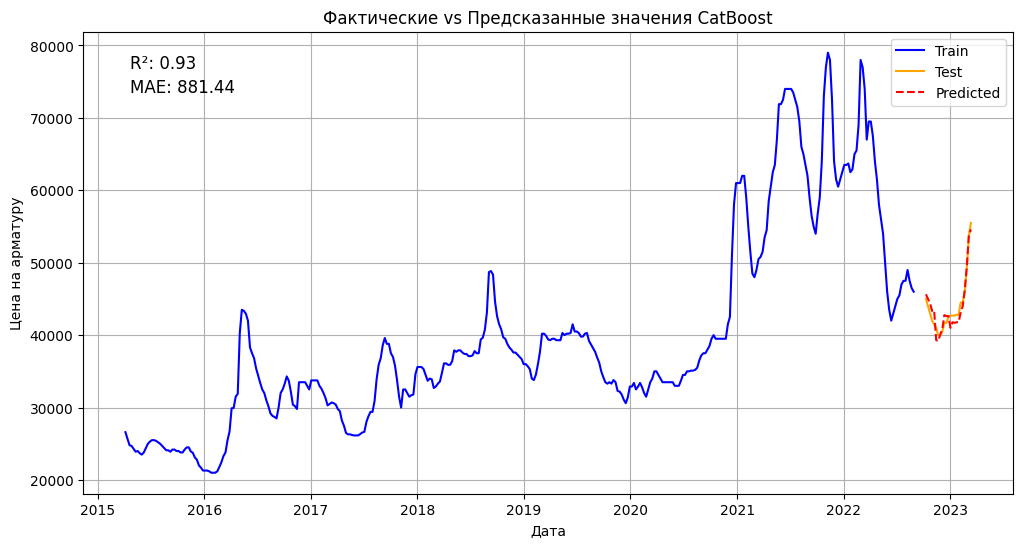

In [896]:
plt.figure(figsize=(12, 6))
plt.plot(train['dt'], y, label='Train', color='blue')  # фактические значения для обучения
plt.plot(test['dt'], y_test, label='Test', color='orange')  # фактические значения для тестирования
plt.plot(test['dt'], y_pred, label='Predicted', color='red', linestyle='dashed')  # предсказанные значения
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.title('Фактические vs Предсказанные значения CatBoost')
# Добавление метрик на график
plt.text(0.05, 0.95, f'R²: {test_r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f'MAE: {test_mae:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend()
plt.grid()
plt.show()

Модель XGBoost

In [897]:
# Подбор гиперпараметров
param_grid_xgboost = {
    'n_estimators': [100, 200], # Количество деревьев
    'max_depth': [3, 5, 10], # Максимальная глубина дерева
    'learning_rate': [0.01, 0.1, 0.2], # Определяет, насколько сильно каждое дерево влияет на итоговое предсказание
    'subsample': [0.8, 1.0] # Этот параметр контролирует, какая доля исходных данных будет использоваться для обучения каждого дерева
}

# Модель
model_xgboost = XGBRegressor(random_state=42) 

grid_search_xgboost = GridSearchCV(model_xgboost, param_grid_xgboost, cv=TSSplit, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_xgboost.fit(X, y)

# Оценка модели
y_pred = grid_search_xgboost.predict(X)
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print(f"XGBoost R2: {r2}")
print(f"XGBoost MAE: {mae}")

XGBoost R2: 1.0
XGBoost MAE: 1.1775577068328857


In [898]:
y_pred = grid_search_xgboost.predict(X_test)

# Оценка модели
test_r2 = r2_score(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred) 

print(f"Test R2: {test_r2}")
print(f"Test MAE: {test_mae}")

Test R2: 0.972109317779541
Test MAE: 455.82183837890625


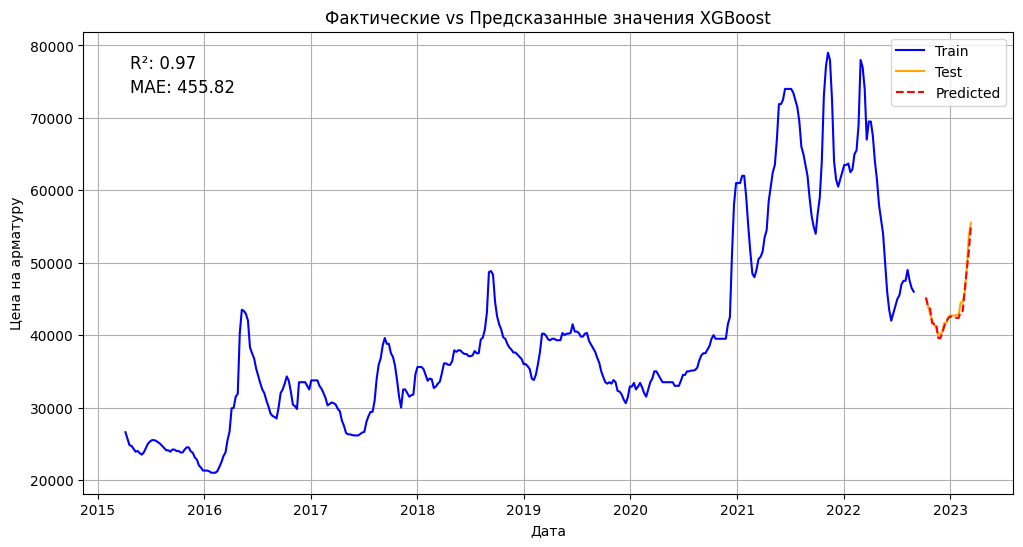

In [899]:
plt.figure(figsize=(12, 6))
plt.plot(train['dt'], y, label='Train', color='blue') 
plt.plot(test['dt'], y_test, label='Test', color='orange')  
plt.plot(test['dt'], y_pred, label='Predicted', color='red', linestyle='dashed') 
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.title('Фактические vs Предсказанные значения XGBoost')
# Добавление метрик на график
plt.text(0.05, 0.95, f'R²: {test_r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f'MAE: {test_mae:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend()
plt.grid()
plt.show()

Модель RandomForest

In [900]:
# Подбор гиперпараметров
param_grid_rf = {
    'n_estimators': [100, 200], # Количество деревьев
    'max_depth': [3, 5, 10], # Максимальная глубина дерева
    'min_samples_split': [2, 5], # Минимальное количество образцов для разбиения узла
    'min_samples_leaf': [1, 2] # Минимальное количество образцов в листовом узле
}

# Модель
model_rf = RandomForestRegressor(random_state=42)

grid_search_rf = GridSearchCV(model_rf, param_grid_rf, cv=TSSplit, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_rf.fit(X, y)

# Оценка модели
y_pred = grid_search_rf.predict(X)
r2_rf = r2_score(y, y_pred)
mae_rf = mean_absolute_error(y, y_pred)  

print(f"Random Forest R2: {r2_rf}")
print(f"Random Forest MAE: {mae_rf}")

Random Forest R2: 0.9990382011195551
Random Forest MAE: 234.7328038739917


In [901]:
y_pred = grid_search_rf.predict(X_test)

test_r2 = r2_score(y_test, y_pred)  
test_mae = mean_absolute_error(y_test, y_pred)

print(f"Test R2: {test_r2}")
print(f"Test MAE: {test_mae}")

Test R2: 0.9388948415375042
Test MAE: 588.1519988749534


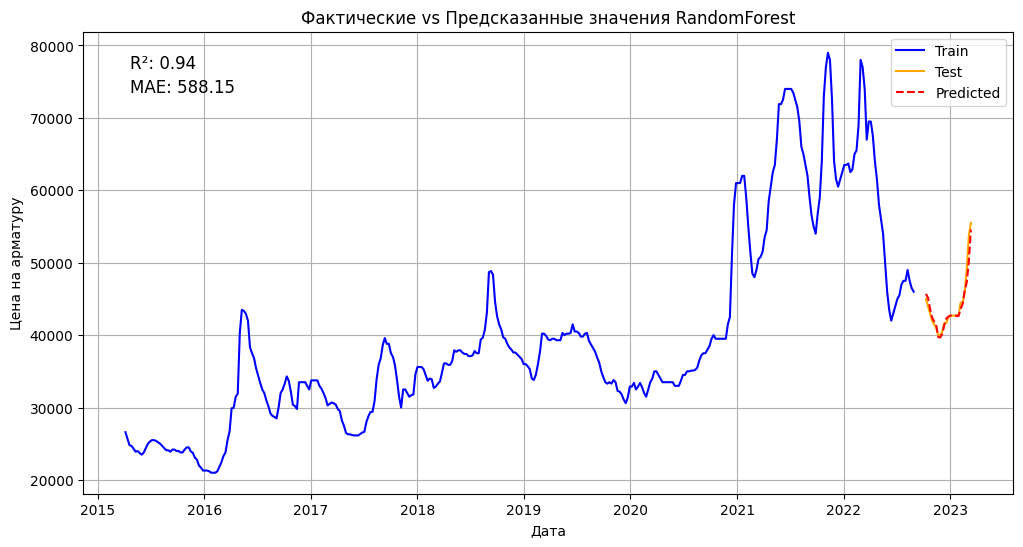

In [902]:
plt.figure(figsize=(12, 6))
plt.plot(train['dt'], y, label='Train', color='blue') 
plt.plot(test['dt'], y_test, label='Test', color='orange')  
plt.plot(test['dt'], y_pred, label='Predicted', color='red', linestyle='dashed') 
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.title('Фактические vs Предсказанные значения RandomForest')
# Добавление метрик на график
plt.text(0.05, 0.95, f'R²: {test_r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f'MAE: {test_mae:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend()
plt.grid()
plt.show()

Вывод: самый точный r2 (XGBoost) & самый точный график (RandomForest)